소수점 싸움에는 약하여 끝에 다른 대회들과 병행하며 하다보니 끝발이 좀 약합니다.... 부족한 코드 봐주셔서 감사합니다.

1. 모델로는 randomForest, lightgbm, xgboost, catboost, ANN, DNN, CNN, RNN 등을 시도해보았으나 xgboost가 가장 점수가 잘나와 xgboost를 선택하였습니다.

2. feature engineering으로는 sdss 페이지들을 많이 참고하였습니다. ugriz 등급끼리 뺄셈을 진행한 feature을 color라고 부르며 이 feature들을 2차평면에 두고 class를 나누는 작업도 하길래 참고하여 clustering을 진행하였지만, accuracy 상승에는 영향이 없어 폐기하였습니다.

3. hyperparameter tuning으로는 Bayesian Optimization이란 방법과 Hyperopt 라이브러리 두가지 모두 사용해보았으나 결과가 좋지 않아 폐기하였습니다.

4. EDA를 진행하였을때 train set과 test set간에 차이가 거의 없음을 인지하였기에 무리하게 fold를 진행하며 general한 모델을 만들려 하진 않았으며, 과하게 overfitting 하는 것 또한 지양하였습니다.

5. 어떤 모델이건 color feature만 추가된다면 기본 정확도가 0.93이 나옵니다. 위에서 시도했다는 모델들의 예측값을 EDA한 결과 모든 모델들이 하나같이 class에서 1과 2를 헷갈려하며 못맞추어 0.93이 나왔습니다. 이후 1과 2는 현재 주어진 data set으로는 더 좋은 accuracy를 가지지 못한다 판단, 이를 구분하기 위한 feature을 찾는 것에 거의 모든 시간을 할애했지만, 결국엔 찾지 못하였습니다.


In [1]:
# import library
import numpy as np
import math
import xgboost as xgb
import pandas as pd
import random as rd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from datetime import datetime
%matplotlib inline

Connect with my google drive; gpu를 사용하기 위해 구글 코랩에서 작업하였으며 train set, test set 및 submission 파일을 읽어오기 위해 구글 드라이브와 연결하였습니다.

In [2]:
# connect with my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


자신의 구글 드라이브에 데이터셋 경로를 넣습니다.

In [3]:
# google drive path
path = '/content/drive/My Drive/Colab Notebooks/단국대 소중 데이터 분석/'

In [4]:
# load data
train = pd.read_csv(path + "train.csv", index_col=0)
test = pd.read_csv(path + "test.csv", index_col=0).reset_index(drop=True)
submission = pd.read_csv(path + "sample_submission.csv")

이번대회에 사실상 더 이상의 의미있는 feature는 없다고 할만큼 중요한 feature인 color 입니다.

In [5]:
# color
train['u-g'] = train['u'] - train['g']
train['g-r'] = train['g'] - train['r']
train['r-i'] = train['r'] - train['i']
train['i-z'] = train['i'] - train['z']
train['dered_u-g'] = train['dered_u'] - train['dered_g']
train['dered_g-r'] = train['dered_g'] - train['dered_r']
train['dered_r-i'] = train['dered_r'] - train['dered_i']
train['dered_i-z'] = train['dered_i'] - train['dered_z']

test['u-g'] = test['u'] - test['g']
test['g-r'] = test['g'] - test['r']
test['r-i'] = test['r'] - test['i']
test['i-z'] = test['i'] - test['z']
test['dered_u-g'] = test['dered_u'] - test['dered_g']
test['dered_g-r'] = test['dered_g'] - test['dered_r']
test['dered_r-i'] = test['dered_r'] - test['dered_i']
test['dered_i-z'] = test['dered_i'] - test['dered_z']

In [6]:
# color * redshift
train['r_u-g'] = train['redshift'] * train['u-g']
train['r_g-r'] = train['redshift'] * train['g-r']
train['r_r-i'] = train['redshift'] * train['r-i']
train['r_i-z'] = train['redshift'] * train['i-z']
train['r_dered_u-g'] = train['redshift'] * train['dered_u-g']
train['r_dered_g-r'] = train['redshift'] * train['dered_g-r']
train['r_dered_r-i'] = train['redshift'] * train['dered_r-i']
train['r_dered_i-z'] = train['redshift'] * train['dered_i-z']

test['r_u-g'] = test['redshift'] * test['u-g']
test['r_g-r'] = test['redshift'] * test['g-r']
test['r_r-i'] = test['redshift'] * test['r-i']
test['r_i-z'] = test['redshift'] * test['i-z']
test['r_dered_u-g'] = test['redshift'] * test['dered_u-g']
test['r_dered_g-r'] = test['redshift'] * test['dered_g-r']
test['r_dered_r-i'] = test['redshift'] * test['dered_r-i']
test['r_dered_i-z'] = test['redshift'] * test['dered_i-z']

ugriz의 max, min, max-min, std, sum의 값을 구하려 하였으나 좀 꼬인 코드입니다. 하지만 accuracy 상승에 효과적이여서 그대로 두었습니다.

In [7]:
ugriz = ['u', 'g', 'r', 'i', 'z']

for a, b in zip(ugriz, [ugriz, ugriz, ugriz, ugriz, ugriz]):
    train[f'{a}_max'] = train[b].max(axis=1)
    test[f'{a}_max'] = test[b].max(axis=1)
    
    train[f'{a}_min'] = train[b].min(axis=1)
    test[f'{a}_min'] = test[b].min(axis=1)
    
    train[f'{a}_diff'] = train[f'{a}_max'] - train[f'{a}_min']
    test[f'{a}_diff'] = test[f'{a}_max'] - test[f'{a}_min']
    
    train[f'{a}_sum'] = train[b].sum(axis=1)
    test[f'{a}_sum'] = test[b].sum(axis=1)

In [8]:
dered_ugriz = ['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']

for a, b in zip(dered_ugriz, [dered_ugriz, dered_ugriz, dered_ugriz, dered_ugriz, dered_ugriz]):
    train[f'{a}_max'] = train[b].max(axis=1)
    test[f'{a}_max'] = test[b].max(axis=1)
    
    train[f'{a}_min'] = train[b].min(axis=1)
    test[f'{a}_min'] = test[b].min(axis=1)
    
    train[f'{a}_diff'] = train[f'{a}_max'] - train[f'{a}_min']
    test[f'{a}_diff'] = test[f'{a}_max'] - test[f'{a}_min']
    
    train[f'{a}_sum'] = train[b].sum(axis=1)
    test[f'{a}_sum'] = test[b].sum(axis=1)

적색편이를 이용하여 거리를 측정하는 feature인데, 음수일 경우엔 사실 사용하면 안되는 식이긴 하나 accuracy 상승에 효과적이라 추가하였습니다.

In [9]:
# https://classic.sdss.org/education/kron_ARCS.pdf
distance_train = []
for rs in train['redshift']:
    if rs > 0:
        distance_train.append((rs / (1+rs)) * 13.5 * 10**9)
    else:
        distance_train.append((abs(rs-1) / abs(rs)) * 13.5 * 10**9)

train['distance'] = distance_train

In [10]:
highest_train = []
for u, g, r, i, z in zip(train['dered_u'], train['dered_g'], train['dered_r'], train['dered_i'], train['dered_z']):
    if max([u, g, r, i, z]) == u:
        highest_train.append(u)
    elif max([u, g, r, i, z]) == g:
        highest_train.append(g)
    elif max([u, g, r, i, z]) == r:
        highest_train.append(r)
    elif max([u, g, r, i, z]) == i:
        highest_train.append(i)
    elif max([u, g, r, i, z]) == z:
        highest_train.append(z)
train['highest'] = highest_train
train['M'] = train['highest'] - 5*(np.log(train['distance']) - 1)

In [11]:
# https://classic.sdss.org/education/kron_ARCS.pdf
distance_test = []
for rs in test['redshift']:
    if rs > 0:
        distance_test.append((rs / (1+rs)) * 13.5 * 10**9)
    else:
        distance_test.append((abs(rs-1) / abs(rs)) * 13.5 * 10**9)

test['distance'] = distance_test

In [12]:
highest_test = []
for u, g, r, i, z in zip(test['dered_u'], test['dered_g'], test['dered_r'], test['dered_i'], test['dered_z']):
    if max([u, g, r, i, z]) == u:
        highest_test.append(u)
    elif max([u, g, r, i, z]) == g:
        highest_test.append(g)
    elif max([u, g, r, i, z]) == r:
        highest_test.append(r)
    elif max([u, g, r, i, z]) == i:
        highest_test.append(i)
    elif max([u, g, r, i, z]) == z:
        highest_test.append(z)
test['highest'] = highest_test
test['M'] = test['highest'] - 5*(np.log(test['distance']) - 1)

SDSS 공식 싸이트에서 찾아봤으나 class를 구분하는덴 의미없다고 판단한 n형제(nObserve, nDetect)입니다.

In [13]:
# n값 처리
train['nO-nD'] = train['nObserve'] - train['nDetect']
test['nO-nD'] = test['nObserve'] - test['nDetect']

이 대회의 데이터가 다른 SDSS 대회들과는 차별화되는 것이 바로 rare한 ugriz, 적색편이값으로 수정된 dered_ugriz, 그리고 각 등급에 대한 airmass(AM)값이 주어졌다는 것이기에, 이들간의 연산을 진행해보았습니다.

In [14]:
# 단순 나눗셈
train['u/dered_u'] = train['u'] / train['dered_u'] - 1
train['g/dered_g'] = train['g'] / train['dered_g'] - 1
train['r/dered_r'] = train['r'] / train['dered_r'] - 1
train['i/dered_i'] = train['i'] / train['dered_i'] - 1
train['z/dered_z'] = train['z'] / train['dered_z'] - 1

test['u/dered_u'] = test['u'] / test['dered_u'] - 1
test['g/dered_g'] = test['g'] / test['dered_g'] - 1
test['r/dered_r'] = test['r'] / test['dered_r'] - 1
test['i/dered_i'] = test['i'] / test['dered_i'] - 1
test['z/dered_z'] = test['z'] / test['dered_z'] - 1

dered_ugriz값들을 절대등급으로 볼것인가 아니면 절대등급을 따로 구할 것인가 고민하다가 accuracy 상승에 효과적이기 때문에 따로 추가하였습니다.

In [15]:
# 계산 결과 이상치 때문에 완벽하진 않지만 절대등급을 구해보았습니다.
train['M_u'] = train['u'] - 5*(np.log(train['distance']) - 1)
train['M_g'] = train['g'] - 5*(np.log(train['distance']) - 1)
train['M_r'] = train['r'] - 5*(np.log(train['distance']) - 1)
train['M_i'] = train['i'] - 5*(np.log(train['distance']) - 1)
train['M_z'] = train['z'] - 5*(np.log(train['distance']) - 1)
train['M_dered_u'] = train['dered_u'] - 5*(np.log(train['distance']) - 1)
train['M_dered_g'] = train['dered_g'] - 5*(np.log(train['distance']) - 1)
train['M_dered_r'] = train['dered_r'] - 5*(np.log(train['distance']) - 1)
train['M_dered_i'] = train['dered_i'] - 5*(np.log(train['distance']) - 1)
train['M_dered_z'] = train['dered_z'] - 5*(np.log(train['distance']) - 1)

test['M_u'] = test['u'] - 5*(np.log(test['distance']) - 1)
test['M_g'] = test['g'] - 5*(np.log(test['distance']) - 1)
test['M_r'] = test['r'] - 5*(np.log(test['distance']) - 1)
test['M_i'] = test['i'] - 5*(np.log(test['distance']) - 1)
test['M_z'] = test['z'] - 5*(np.log(test['distance']) - 1)
test['M_dered_u'] = test['dered_u'] - 5*(np.log(test['distance']) - 1)
test['M_dered_g'] = test['dered_g'] - 5*(np.log(test['distance']) - 1)
test['M_dered_r'] = test['dered_r'] - 5*(np.log(test['distance']) - 1)
test['M_dered_i'] = test['dered_i'] - 5*(np.log(test['distance']) - 1)
test['M_dered_z'] = test['dered_z'] - 5*(np.log(test['distance']) - 1)

In [16]:
# feature importance를 확인하여 0인 값들만 제거하였습니다.
bad_feature = ['g_max', 'g_min', 'g_diff', 'g_sum', 'r_max', 'r_min', 'r_diff', 'r_sum',
               'i_max', 'i_min', 'i_diff', 'i_sum', 'z_max', 'z_min', 'z_diff', 'z_sum',
               'dered_g_max', 'dered_g_min', 'dered_g_diff', 'dered_g_sum',
               'dered_r_max', 'dered_r_min', 'dered_r_diff', 'dered_r_sum',
               'dered_i_max', 'dered_i_min', 'dered_i_diff', 'dered_i_sum',
               'dered_z_max', 'dered_z_min', 'dered_z_diff', 'dered_z_sum',
               'class']

In [17]:
useful_columns = [c for c in train.columns if c not in bad_feature]

In [18]:
# split data into X and Y

X = train[useful_columns]
Y = train['class']

In [19]:
X

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u-g,g-r,r-i,i-z,dered_u-g,dered_g-r,dered_r-i,dered_i-z,r_u-g,r_g-r,r_r-i,r_i-z,r_dered_u-g,r_dered_g-r,r_dered_r-i,r_dered_i-z,u_max,u_min,u_diff,u_sum,dered_u_max,dered_u_min,dered_u_diff,dered_u_sum,distance,highest,M,nO-nD,u/dered_u,g/dered_g,r/dered_r,i/dered_i,z/dered_z,M_u,M_g,M_r,M_i,M_z,M_dered_u,M_dered_g,M_dered_r,M_dered_i,M_dered_z
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.263956,20.336773,19.009500,17.672439,16.939607,-0.000081,23.12426,20.25779,18.95512,17.63211,16.90894,18,18,1.189764,1.190681,1.188979,1.189355,1.190206,2.927183,1.327273,1.337061,0.732833,2.86647,1.30267,1.32301,0.72317,-0.000237,-0.000108,-0.000108,-0.000059,-0.000232,-0.000106,-1.072779e-04,-5.863916e-05,23.263956,16.939607,6.324349,97.222276,23.12426,16.90894,6.21532,96.87822,1.665028e+14,23.12426,-135.605907,0,0.006041,0.003899,0.002869,0.002287,0.001814,-135.466211,-138.393394,-139.720667,-141.057728,-141.790561,-135.605907,-138.472377,-139.775047,-141.098057,-141.821227
1,15.052147,14.061969,13.452418,13.268450,13.168941,0.004506,14.96642,14.00452,13.41139,13.23625,13.13468,1,1,1.253254,1.257836,1.248762,1.250997,1.255533,0.990179,0.609551,0.183968,0.099509,0.96190,0.59313,0.17514,0.10157,0.004462,0.002747,0.000829,0.000448,0.004334,0.002673,7.891931e-04,4.576815e-04,15.052147,13.168941,1.883207,69.003924,14.96642,13.13468,1.83174,68.75326,6.055906e+07,14.96642,-69.629228,0,0.005728,0.004102,0.003059,0.002433,0.002608,-69.543501,-70.533679,-71.143230,-71.327199,-71.426708,-69.629228,-70.591128,-71.184258,-71.359398,-71.460968
2,16.786385,15.825426,15.536318,15.393535,15.350032,0.000472,16.60765,15.68659,15.44004,15.32173,15.29608,2,2,1.022499,1.024105,1.020983,1.021730,1.023291,0.960959,0.289108,0.142783,0.043503,0.92106,0.24655,0.11831,0.02565,0.000454,0.000136,0.000067,0.000021,0.000435,0.000116,5.583959e-05,1.210621e-05,16.786385,15.350032,1.436353,78.891695,16.60765,15.29608,1.31157,78.35209,6.368682e+06,16.60765,-56.726866,0,0.010762,0.008851,0.006236,0.004686,0.003527,-56.548131,-57.509090,-57.798198,-57.940981,-57.984484,-56.726866,-57.647926,-57.894476,-58.012786,-58.038436
3,25.660638,21.188727,20.221158,19.894949,19.634649,0.000006,25.35365,20.99465,20.08727,19.79465,19.55518,4,3,1.205399,1.206058,1.204874,1.205120,1.205712,4.471910,0.967569,0.326209,0.260300,4.35900,0.90738,0.29262,0.23947,0.000026,0.000006,0.000002,0.000002,0.000025,0.000005,1.701380e-06,1.392350e-06,25.660638,19.634649,6.025989,106.600122,25.35365,19.55518,5.79847,105.78540,7.849255e+04,25.35365,-26.000145,1,0.012108,0.009244,0.006665,0.005067,0.004064,-25.693157,-30.165068,-31.132637,-31.458846,-31.719146,-26.000145,-30.359145,-31.266525,-31.559145,-31.798615
4,24.453429,20.699170,19.042368,18.324152,17.982649,-0.000033,23.77140,20.43384,18.86299,18.19028,17.87592,13,12,1.193946,1.194285,1.193738,1.193826,1.194099,3.754259,1.656803,0.718216,0.341503,3.33756,1.57085,0.67271,0.31436,-0.000125,-0.000055,-0.000024,-0.000011,-0.000111,-0.000052,-2.236563e-05,-1.045155e-05,24.453429,17.982649,6.470780,100.501768,23.77140,17.87592,5.89548,99.13443,4.060645e+14,23.77140,-139.416265,1,0.028691,0.012985,0.009509,0.007360,0.005971,-138.734236,-142.488495,-144.145298,-144.863513,-145.205016,-139.416265,-142.753825,-144.324675,-144.997385,-145.311745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,18.365648,17.240883,16.773898,16.484970,16.340403,0.051988,18.13280,17.04065,16.63744,16.38606,16.28741,2,2,1.093010,1.088828,1.097310,1.095145,1.090905,1.124765,0.466985,0.288928,0.144567,1.09215,0.40321,0.25138,0.09865,0.058474,0.024277,0.015021,0.007516,0.056778,0.020962,1.306864e-02,5.128574e-03,18.365648,16.340403,2.02

In [20]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=seed)
eval_set = [(X_val, y_val)]

모델 학습을 진행합니다.

In [21]:
start_time = datetime.now()

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    booster='gbtree',
    max_depth=12,
    learning_rate=0.1,
    n_estimators=500,
    scale_pos_weight=1.2,
    eval_metric='merror',
    eval_set=eval_set,
    early_stopping_rounds=20,
    tree_method='gpu_hist'
)

model.fit(X_train, y_train)

end_time = datetime.now() 
print("\nelapsed time = ", end_time - start_time)


elapsed time =  0:05:31.082998


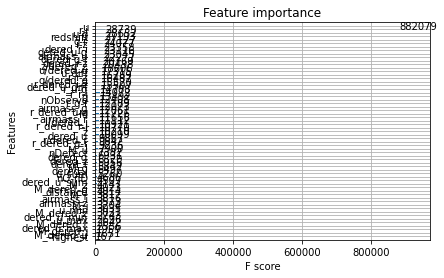

In [22]:
plot_importance(model)

정확도를 측정해봅니다.

In [23]:
model_pred = model.predict(X_val)
accuracy_score(y_val, model_pred)

0.936

제출파일을 생성합니다.

In [24]:
pred = model.predict(test[useful_columns])
submission['class'] = pred
submission.to_csv(path + "submission_xgb.csv",index=False, encoding='utf-8-sig')